# IBM Data Science Professional Certificate Capstone Project Notebook

### Introduction and Business Problem

- The city of Lucknow, Uttar Pradesh,India is relatively small at ~1 square mile but it is packed with restaurants, night life and amazing people. For people that are new to Lucknow, despite its small geographic size, it can be daunting to figure out what restaurants are worth going to and where they are.  For people that used to live in Lucknow or are visiting Lucknow, how do you know what the best places are to get something to eat?

- For this project, I am going to create a simple guide on where to eat based on Foursquare likes, restaurant category and geographic location data for restaurants in Lucknow. I will then cluster these restaurants based on their similarities so that a user can easily determine what type of restaurants are best to eat at based on Foursquare user feedback.

#### For Detailed Info Please Refer  - [https://github.com/shashwatwork/Coursera_Capstone/blob/master/Final_Doc_Capstone.pdf](Hidden_landing_URL)

## Challenges Faced - 

- Due to very less number of coordinates found using Four Squares API Proper Cluster are not formed .This is may be due to API’s does not list all Resturants and cuisines available in Lucknow or due to lack of Digitilization of City.

In [80]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup
from urllib.request import urlopen
from bs4 import BeautifulSoup


print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.19.0                     py_0    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


## Finding the geo data for Lucknow¶

In [97]:
address = 'Lucknow,India'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lucknow are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.19.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Lucknow are 18.9387711, 72.8353355.


## Entering  info into the Foursquare API to access it.

In [124]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


## Creating a URL for all of the venues in Lucknow

In [99]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=LI0QI4XRGICKIEAMN2GKO3BZTJV3HWMPZ02STZ2VNPV2TW25&client_secret=VU5GEYTLBIFB5K432F0KDBFKGPW5BWPMOYZ1QLTM5MLERXTM&v=20180605&ll=18.9387711,72.8353355&radius=500&limit=100'

In [100]:
# Pulling out Json url's
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5caa17079fb6b713f94eb499'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4caa0096d971b1f7ccca23e1-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d145941735',
         'name': 'Chinese Restaurant',
         'pluralName': 'Chinese Restaurants',
         'primary': True,
         'shortName': 'Chinese'}],
       'id': '4caa0096d971b1f7ccca23e1',
       'location': {'address': 'Waudby Road',
        'cc': 'IN',
        'city': 'Mumbai',
        'country': 'India',
        'distance': 253,
        'formattedAddress': ['Waudby Road', 'Mumbai', 'Mahārāshtra', 'India'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 18.938715239156295,
          'ln

## Extract the data from Foursquare API into a dataframe 

In [101]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [102]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853
5,Sterling Cineplex,4bb483c6737d76b0e86f3b7c,Multiplex,18.938296,72.833104
6,Cannon Pav Bhaji,4bdac9bb2a3a0f47edf9abb6,Food Truck,18.940780,72.836007
7,Dakshin Bar And Kitchen,5215d00311d235bf4fe158e9,Seafood Restaurant,18.936489,72.837490
8,McDonald's,4b7b66b2f964a52011622fe3,Fast Food Restaurant,18.938985,72.834504
9,Bombay Gymkhana,4b0587e6f964a52068a622e3,Athletics & Sports,18.937691,72.830976


In [103]:
#fix the column names so they look relatively normal

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853
5,Sterling Cineplex,4bb483c6737d76b0e86f3b7c,Multiplex,18.938296,72.833104
6,Cannon Pav Bhaji,4bdac9bb2a3a0f47edf9abb6,Food Truck,18.940780,72.836007
7,Dakshin Bar And Kitchen,5215d00311d235bf4fe158e9,Seafood Restaurant,18.936489,72.837490
8,McDonald's,4b7b66b2f964a52011622fe3,Fast Food Restaurant,18.938985,72.834504
9,Bombay Gymkhana,4b0587e6f964a52068a622e3,Athletics & Sports,18.937691,72.830976


In [104]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['categories'].unique()

array(['Chinese Restaurant', 'Bar', 'Train Station', 'Café',
       'Indian Restaurant', 'Multiplex', 'Food Truck',
       'Seafood Restaurant', 'Fast Food Restaurant', 'Athletics & Sports',
       'Irani Cafe', 'Hotel', 'Sandwich Place', 'Lounge'], dtype=object)

In [105]:
# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Gym / Fitness Center', 'Bakery', 'Park', "Women's Store", 'Sporting Goods Shop', 'Dog Run', 'Gaming Cafe',
               'Optical Shop', 'Yoga Studio', 'Pet Store', 'Shoe Repair', 'Jewelry Store', 'Record Shop', 'Juice Bar', 
               'Cosmetics Shop', 'Business Service', 'Salon / Barbershop', 'Liquor Store', 'Grocery Store', 'Stationery Store',
               'Pilates Studio', 'Dessert Shop', 'Bookstore', 'Concert Hall', 'Video Game Store', 'Pharmacy', 'Mobile Phone Shop',
               'Deli / Bodega']

nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853
5,Sterling Cineplex,4bb483c6737d76b0e86f3b7c,Multiplex,18.938296,72.833104
6,Cannon Pav Bhaji,4bdac9bb2a3a0f47edf9abb6,Food Truck,18.940780,72.836007
7,Dakshin Bar And Kitchen,5215d00311d235bf4fe158e9,Seafood Restaurant,18.936489,72.837490
8,McDonald's,4b7b66b2f964a52011622fe3,Fast Food Restaurant,18.938985,72.834504
9,Bombay Gymkhana,4b0587e6f964a52068a622e3,Athletics & Sports,18.937691,72.830976


In [106]:
#let's get a list of venues

venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['4caa0096d971b1f7ccca23e1',
 '5263e1ba11d265711e8024bf',
 '4babe4fff964a520f8d23ae3',
 '4c714f4fd7fab1f715d760c9',
 '4b0587d9f964a52023a422e3',
 '4bb483c6737d76b0e86f3b7c',
 '4bdac9bb2a3a0f47edf9abb6',
 '5215d00311d235bf4fe158e9',
 '4b7b66b2f964a52011622fe3',
 '4b0587e6f964a52068a622e3',
 '4e33a472227111ae76912f24',
 '4b585e02f964a520a35428e3',
 '4bdaa0332a3a0f47ad8eabb6',
 '4bcf4de40ffdce72215fb2c0',
 '4f1ed1b7e4b0ab7784c2db4c',
 '4d31c9a072a8b1f7878797d0',
 '4badb63cf964a520a3643be3',
 '4dca583cae607b31c0bdf19c',
 '5810c12738faa0b87f99d404']

In [107]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[35, 16, 299, 31, 16, 138, 33, 5, 81, 27, 24, 60, 18, 14, 7, 3, 8, 19, 8]


In [108]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

19
19


## Data Preparation for Clustering

In [109]:
#let's make a copy of our initial dataframe just in case anything goes wrong

lko_venues = nearby_venues2.copy()
lko_venues.head()

,name,id,categories,lat,lng
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853


In [110]:
# add in the list of likes

lko_venues['total likes'] = like_list
lko_venues.head()

,name,id,categories,lat,lng,total likes
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933,35
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464,16
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384,299
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566,31
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853,16


In [111]:
# now let's bin total likes

print(lko_venues['total likes'].max())
print(lko_venues['total likes'].min())
print(lko_venues['total likes'].median())
print(lko_venues['total likes'].mean())

299
3
19.0
44.31578947368421


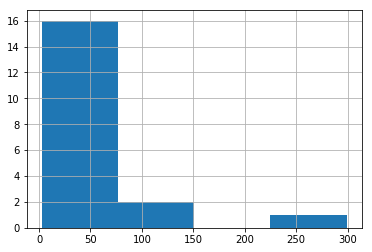

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
lko_venues['total likes'].hist(bins=4)
plt.show()

In [113]:

# what are the bins we want to use?

print(np.percentile(lko_venues['total likes'], 25))
print(np.percentile(lko_venues['total likes'], 50))
print(np.percentile(lko_venues['total likes'], 75))

11.0
19.0
34.0


In [114]:
# now we have our bin values so let's set them to the appropriate values
# less than 24, 24-45, 45-76, 76>
# poor, below avg, abv avg, great

poor = lko_venues['total likes']<=24
below_avg = lko_venues[(lko_venues['total likes']>24) & (lko_venues['total likes']<=45)]
abv_avg = lko_venues[(lko_venues['total likes']>45) & (lko_venues['total likes']<=76)]
great = lko_venues['total likes']>76

In [115]:
def conditions(s):
    if s['total likes']<=24:
        return 'poor'
    if s['total likes']<=45:
        return 'below avg'
    if s['total likes']<=76:
        return 'avg avg'
    if s['total likes']>76:
        return 'great'

lko_venues['total likes_cat']=lko_venues.apply(conditions, axis=1)

In [116]:
lko_venues

,name,id,categories,lat,lng,total likes,total likes_cat
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933,35,below avg
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464,16,poor
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384,299,great
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566,31,below avg
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853,16,poor
5,Sterling Cineplex,4bb483c6737d76b0e86f3b7c,Multiplex,18.938296,72.833104,138,great
6,Cannon Pav Bhaji,4bdac9bb2a3a0f47edf9abb6,Food Truck,18.940780,72.836007,33,below avg
7,Dakshin Bar And Kitchen,5215d00311d235bf4fe158e9,Seafood Restaurant,18.936489,72.837490,5,poor
8,McDonald's,4b7b66b2f964a52011622fe3,Fast Food Restaurant,18.938985,72.834504,81,great
9,Bombay Gymkhana,4b0587e6f964a52068a622e3,Athletics & Sports,18.937691,72.830976,27,below avg


In [117]:
lko_venues['categories'].unique()

array(['Chinese Restaurant', 'Bar', 'Train Station', 'Café',
       'Indian Restaurant', 'Multiplex', 'Food Truck',
       'Seafood Restaurant', 'Fast Food Restaurant', 'Athletics & Sports',
       'Irani Cafe', 'Hotel', 'Sandwich Place', 'Lounge'], dtype=object)

In [118]:
# let's create our new categories and create a function to apply those to our existing data


bars = ['Pub', 'Cocktail Bar', 'Bar', 'Dive Bar', 'Sports Bar']
other = ['Bagel Shop', 'Tea Room', 'Donut Shop', 'Coffee Shop', 'Bubble Tea Shop', 'Sandwich Place', 'Boutique', 'Ice Cream Shop']
euro_asia_indian_food = ['Falafel Restaurant', 'Korean Restaurant','Sushi Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Poke Place', 'Thai Restaurant', 'Vietnamese Restaurant']
mex_southam_food = ['Cuban Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Latin American Restaurant']
american_food = ['Burger Joint', 'Restaurant', 'American Restaurant']
italian_food = ['Italian Restaurant', 'Seafood Restaurant', 'Pizza Place']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in euro_asia_indian_food:
        return 'euro asia indian food'
    if s['categories'] in mex_southam_food:
        return 'mex southam food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in italian_food:
        return 'italian food'

lko_venues['categories_new']=lko_venues.apply(conditions2, axis=1)

In [119]:
lko_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933,35,below avg,None
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464,16,poor,bars
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384,299,great,None
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566,31,below avg,None
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853,16,poor,euro asia indian food
5,Sterling Cineplex,4bb483c6737d76b0e86f3b7c,Multiplex,18.938296,72.833104,138,great,None
6,Cannon Pav Bhaji,4bdac9bb2a3a0f47edf9abb6,Food Truck,18.940780,72.836007,33,below avg,None
7,Dakshin Bar And Kitchen,5215d00311d235bf4fe158e9,Seafood Restaurant,18.936489,72.837490,5,poor,italian food
8,McDonald's,4b7b66b2f964a52011622fe3,Fast Food Restaurant,18.938985,72.834504,81,great,None
9,Bombay Gymkhana,4b0587e6f964a52068a622e3,Athletics & Sports,18.937691,72.830976,27,below avg,None


In [120]:
# one hot encoding
lko_onehot = pd.get_dummies(lko_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lko_onehot['Name'] = lko_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [lko_onehot.columns[-1]] + list(lko_onehot.columns[:-1])
lko_onehot = lko_onehot[fixed_columns]

lko_onehot.head()

,Name,bars,euro asia indian food,italian food,other,avg avg,below avg,great,poor
0,Royal China,0,0,0,0,0,1,0,0
1,Town House Cafe,1,0,0,0,0,0,0,1
2,Chhatrapati Shivaji Maharaj Terminus,0,0,0,0,0,0,1,0
3,Cafe Excelsior,0,0,0,0,0,1,0,0
4,Sher-E-Punjab,0,1,0,0,0,0,0,1


## Kicking off Kmeans Clusters!

In [121]:
cluster_df = lko_onehot.drop('Name', axis=1)

k_clusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0], dtype=int32)

In [122]:
lko_venues['label'] = kmeans.labels_
lko_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933,35,below avg,None,0
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464,16,poor,bars,1
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384,299,great,None,2
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566,31,below avg,None,0
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853,16,poor,euro asia indian food,1


##  Visualize Cluster using Maps!

In [123]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lko_venues['lat'], lko_venues['lng'], lko_venues['name'], lko_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## Cluster - I

In [125]:
lko_venues.loc[lko_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Royal China,4caa0096d971b1f7ccca23e1,Chinese Restaurant,18.938715,72.832933,35,below avg,None,0
3,Cafe Excelsior,4c714f4fd7fab1f715d760c9,Café,18.937701,72.833566,31,below avg,None,0
6,Cannon Pav Bhaji,4bdac9bb2a3a0f47edf9abb6,Food Truck,18.940780,72.836007,33,below avg,None,0
9,Bombay Gymkhana,4b0587e6f964a52068a622e3,Athletics & Sports,18.937691,72.830976,27,below avg,None,0
11,Café Universal,4b585e02f964a520a35428e3,Irani Cafe,18.936021,72.837453,60,avg avg,None,0


## Cluster - II

In [126]:
lko_venues.loc[lko_venues['label']==1]


,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
1,Town House Cafe,5263e1ba11d265711e8024bf,Bar,18.938550,72.833464,16,poor,bars,1
4,Sher-E-Punjab,4b0587d9f964a52023a422e3,Indian Restaurant,18.937944,72.837853,16,poor,euro asia indian food,1
7,Dakshin Bar And Kitchen,5215d00311d235bf4fe158e9,Seafood Restaurant,18.936489,72.837490,5,poor,italian food,1
10,Pancham Puriwala,4e33a472227111ae76912f24,Indian Restaurant,18.938214,72.835697,24,poor,euro asia indian food,1
12,Ideal Corner,4bdaa0332a3a0f47ad8eabb6,Indian Restaurant,18.934961,72.834050,18,poor,euro asia indian food,1
13,Residency Hotel,4bcf4de40ffdce72215fb2c0,Hotel,18.934978,72.833481,14,poor,None,1
14,Kayani Restaurant,4f1ed1b7e4b0ab7784c2db4c,Irani Cafe,18.935040,72.836941,7,poor,None,1
15,Hotel Fountain Plaza,4d31c9a072a8b1f7878797d0,Indian Restaurant,18.935671,72.834030,3,poor,euro asia indian food,1
16,Subway,4badb63cf964a520a3643be3,Sandwich Place,18.938250,72.833027,8,poor,other,1
17,Press Club Mumbai,4dca583cae607b31c0bdf19c,Bar,18.940721,72.832469,19,poor,bars,1


## Cluster - III

In [127]:
lko_venues.loc[lko_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,Chhatrapati Shivaji Maharaj Terminus,4babe4fff964a520f8d23ae3,Train Station,18.940297,72.835384,299,great,None,2
5,Sterling Cineplex,4bb483c6737d76b0e86f3b7c,Multiplex,18.938296,72.833104,138,great,None,2
8,McDonald's,4b7b66b2f964a52011622fe3,Fast Food Restaurant,18.938985,72.834504,81,great,None,2


## End of Story !